# Import libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
from PIL import Image
import os
import numpy as np

# Database creations using pytorch Dataset 

In [3]:
class ImageAuthenticityDataset(Dataset):
    """Dataset for image quality assessment."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.dir_path = os.path.dirname(csv_file)  # Directory of the CSV file

    def __len__(self):
        """Returns the number of samples in the dataset."""
        return len(self.data)

    def __getitem__(self, idx,):
        """
        Retrieves an image and its labels by index.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: A tuple (image, labels) where:
                image (PIL.Image): The image.
                labels (torch.Tensor): Tensor containing quality and authenticity scores.
        """
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # TODO: to be fixed, right now is folder dependent
        img_name = self.data.iloc[idx, 3].replace("./", "../../")
        image = Image.open(img_name).convert('RGB')
        authenticity = self.data.iloc[idx, 1]  # Authenticity column
        labels = torch.tensor([authenticity], dtype=torch.float)


        if self.transform:
            image = self.transform(image)

        return image, labels


# Definitions of the models

In [4]:
class AuthenticityPredictor(nn.Module):
    def __init__(self, freeze_backbone=True):
        super().__init__()
        # Load pre-trained InceptionV3 instead of ResNet152
        inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        
        # Disable auxiliary outputs for inference
        inception.aux_logits = False
        
        # Freeze backbone if requested
        if freeze_backbone:
            for param in inception.parameters():
                param.requires_grad = False
        
        # Store the backbone (excluding the final fc layer)
        # InceptionV3 structure is different from ResNet, so we need to adapt
        self.features = nn.Sequential(
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1,
            inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b,
            inception.Mixed_5c,
            inception.Mixed_5d,
            inception.Mixed_6a,
            inception.Mixed_6b,
            inception.Mixed_6c,
            inception.Mixed_6d,
            inception.Mixed_6e,
            inception.Mixed_7a,
            inception.Mixed_7b,
            inception.Mixed_7c
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.regression_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.5),  
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 1)
        )    
        
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        predictions = self.regression_head(x)
        return predictions, x  # Return predictions and features

## Setup section

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformations for the ImageNet dataset
data_transforms = transforms.Compose([
    transforms.Resize(342),
    transforms.CenterCrop(299),  # InceptionV3 uses 299×299 images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

annotations_file = '../../Dataset/AIGCIQA2023/real_images_annotations.csv'

# Create the dataset
dataset = ImageAuthenticityDataset(csv_file=annotations_file, transform=data_transforms)

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Split the dataset into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


# Create data loaders
BATCH_SIZE = 1 # Set to 1 for handling individual images


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


# Create a dictionary containing the data loaders
dataloaders = {
    'train': train_dataloader,
    'val': val_dataloader,
    'test': test_dataloader
}


# Models loading

In [6]:
BASELINE_MODEL_PATH = 'Weights/Inception-v3_real_authenticity_finetuned.pth'

baseline_model = AuthenticityPredictor()
baseline_model.load_state_dict(torch.load(BASELINE_MODEL_PATH,weights_only=True))

<All keys matched successfully>

# 1) Sort the importance scores by channel ID and normalize them to sum to 1

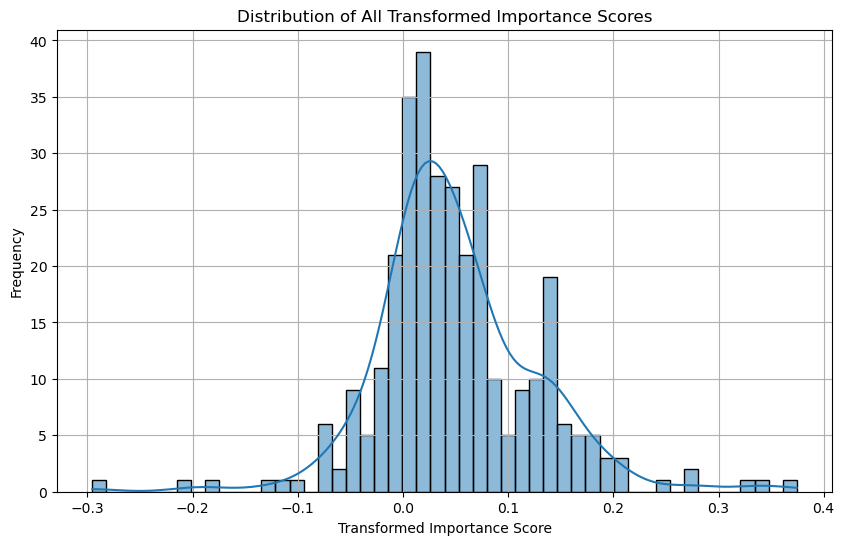

In [7]:
# Load the array of arrays
importance_scores = np.load('Ranking_arrays/Dual_scores_obj_x_obj_authenticity_importance_scores.npy', allow_pickle=True)

# Fix the array creation with proper generator expressions
delta_residuals_scores = np.array([pair[0] for pair in importance_scores])
delta_predictions_scores = np.array([pair[1] for pair in importance_scores])

def extract_sign(scores):
    """Extract the sign of the scores."""
    return np.sign(scores)


def z_score_normalize(scores):
    """Normalize the scores using Z-score normalization."""
    mean = np.mean(scores)
    std = np.std(scores)
    normalized_scores = (scores - mean) / std
    return normalized_scores

def transform_scores(scores, signs):
    """Transform the scores based on their sign."""
    scores= abs(scores)
    scores = scores * signs
    return scores


# # Initialize array with same structure but with zeros
transformed_importance_scores = np.empty_like(importance_scores, dtype=object)

# Apply the transformation to each importance score array
for i in range(len(delta_predictions_scores)):
    # Convert to numpy array if it's not already (for object arrays)
    if not isinstance(delta_predictions_scores[i], np.ndarray):
        delta_predictions_scores[i] = np.array(delta_predictions_scores[i])
    transformed_importance_scores[i] = transform_scores(delta_predictions_scores[i], extract_sign(delta_residuals_scores[i]))


# distribution of the transformed importance scores
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(10, 6))
sns.histplot(transformed_importance_scores[0], bins=50, kde=True)
plt.title('Distribution of All Transformed Importance Scores')
plt.xlabel('Transformed Importance Score')
plt.ylabel('Frequency')
plt.grid()
plt.show()




In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm


class AIS:
    """
    Implements CAM for model interpretation.
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        
        self.activations = None
        
        # Register hooks to capture activations and gradients
        self.register_hooks()
        
    def register_hooks(self):
        def forward_hook(module, input, output):
            # Store the activations of the target layer
            self.activations = output.detach()
            
        # Register the hooks
        self.target_layer.register_forward_hook(forward_hook)
        
    def generate_ais(self, input_image, importance_scores=None):
        # Forward pass through the model
        model_output, _ = self.model(input_image)
        
        # Get the activations
        activations = self.activations.data.cpu().numpy()[0]  # [C, H, W]

        print(f"Activations shape: {activations.shape}")
        print(f"Importance scores shape: {importance_scores.shape}")
        
        # Relu the activations to focus on positive influences
        activations = np.maximum(activations, 0)
        
        # Weight the channels by the importance scores
        weights = importance_scores  # Use the instance variable
            
        # Create weighted combination of activation maps
        ais = np.zeros(activations.shape[1:], dtype=np.float32)  # [H, W]
        
        # Handle the case where weights might be multi-dimensional
        if len(weights.shape) == 1 and len(weights) == activations.shape[0]:
            # Standard case: one weight per channel
            for i, w in enumerate(weights):
                ais += w * activations[i, :, :]
        else:
            # Check the shapes before operation to provide helpful error message
            raise ValueError(f"Incompatible shapes: weights {weights.shape}, activations {activations.shape}")
                
        # Resize ais to input image size
        ais = cv2.resize(ais, (input_image.shape[2], input_image.shape[3]))
        
        # z-score normalization
        ais_mean = np.mean(ais)
        ais_std = np.std(ais)
        ais = (ais - ais_mean) / ais_std
        
        return ais
    
def apply_redblue_ais_to_dataset(model, dataloader, target_layer, output_dir, model_name, device, importance_scores, num_samples=10):
    """
    Apply AIS visualization to a subset of images from the dataset with a red-blue colormap.
    
    Args:
        model: Neural network model
        dataloader: DataLoader containing the images
        target_layer: Target layer for AIS (usually the last convolutional layer)
        output_dir: Directory to save the visualizations
        model_name: Name of the model for saving files
        device: Device to run the model on (cuda/cpu)
        importance_scores: Importance weights for each channel in the target layer
                          (Can contain positive and negative values)
        num_samples: Number of samples to visualize
    """
    # Create model-specific output directory
    model_output_dir = os.path.join(output_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    # Initialize AIS with the model and target layer
    ais_generator = AIS(model, target_layer)
    
    # Move model to device and set to evaluation mode
    model.to(device)
    model.eval()
    
    # Process images from the dataloader
    samples_processed = 0
    
    for batch_idx, (images, labels) in enumerate(dataloader):
        if samples_processed >= num_samples:
            break
            
        images = images.to(device)
        labels = labels.to(device)
        
        for i in range(images.shape[0]):
            if samples_processed >= num_samples:
                break
                
            # Get the single image
            image = images[i:i+1]

            # Determine which importance scores to use based on shape
            if len(importance_scores[i].shape) == 1 and len(importance_scores[i]) == images.shape[1]:
                # Use the importance scores directly
                raw_heatmap = ais_generator.generate_ais(image, importance_scores)
            else:
                # Use the index to access the corresponding importance scores
                raw_heatmap = ais_generator.generate_ais(image, importance_scores[i])

            only_positive_heatmap = np.maximum(raw_heatmap, 0)
            only_negative_heatmap = np.minimum(raw_heatmap, 0)
            
            # Prepare original image for visualization
            img_tensor = images[i].cpu().numpy()
            img_tensor = np.transpose(img_tensor, (1, 2, 0))  # [H, W, C]
            
            # Denormalize the image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_tensor = std * img_tensor + mean
            img_tensor = np.clip(img_tensor, 0, 1)
            
            # Convert to uint8 for OpenCV
            rgb_img = (img_tensor * 255).astype(np.uint8)
            
            # Save original image
            plt.figure()
            plt.imshow(rgb_img)
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'original_images', f"original_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()
            
            #Define colormap and normalization for the heatmap
            norm = TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)
            cmap = cm.get_cmap('bwr', 256)

            # Create the red-blue combined heatmap 
            plt.figure()
            plt.imshow(raw_heatmap, cmap=cmap, norm=norm)
            plt.colorbar(label='Contribution to Realism')
            plt.title("Red: Positive Contribution, Blue: Negative Contribution")
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'combined_raw_heatmap', f"heatmap_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()

            # Create the only positive (red) heatmap
            plt.figure()
            plt.imshow(only_positive_heatmap, cmap=cmap, norm=norm)
            plt.colorbar(label='Positive Contribution to Realism')
            plt.title("Red: Positive Contribution")
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'positive_heatmap', f"positive_heatmap_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()

            # Create the only negative (blue) heatmap
            plt.figure()
            plt.imshow(only_negative_heatmap, cmap=cmap, norm=norm)
            plt.colorbar(label='Negative Contribution to Realism')
            plt.title("Blue: Negative Contribution")
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'negative_heatmap', f"negative_heatmap_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()


            # Create overlay of raw heatmap on original image
            plt.figure(figsize=(10, 8))
            plt.imshow(raw_heatmap, cmap=cmap, norm=norm)
            plt.axis('off')
            # Save to a temporary file
            temp_path = os.path.join(model_output_dir, 'temp', f"temp_heatmap_{samples_processed}.png")
            os.makedirs(os.path.dirname(temp_path), exist_ok=True)
            plt.savefig(temp_path, bbox_inches='tight', pad_inches=0, dpi=150)
            plt.close()
            
            # Read the colored heatmap with OpenCV
            colored_heatmap = cv2.imread(temp_path)
            # Resize heatmap to match the image size
            colored_heatmap = cv2.resize(colored_heatmap, (rgb_img.shape[1], rgb_img.shape[0]))
            
            # Create overlay of heatmap on original image
            # We need to convert RGB to BGR for OpenCV
            bgr_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
            overlay = cv2.addWeighted(bgr_img, 0.6, colored_heatmap, 0.4, 0)
            
            # Save overlay
            plt.figure()
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'overlay', f"overlay_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()
            
            # Create overlay of positive heatmap on original image
            plt.figure(figsize=(10, 8))
            plt.imshow(only_positive_heatmap, cmap=cmap, norm=norm)
            plt.axis('off')
            temp_pos_path = os.path.join(model_output_dir, 'temp', f"temp_pos_heatmap_{samples_processed}.png")
            plt.savefig(temp_pos_path, bbox_inches='tight', pad_inches=0, dpi=150)
            plt.close()
            
            # Read the colored positive heatmap with OpenCV
            colored_pos_heatmap = cv2.imread(temp_pos_path)
            colored_pos_heatmap = cv2.resize(colored_pos_heatmap, (rgb_img.shape[1], rgb_img.shape[0]))
            overlay_pos = cv2.addWeighted(bgr_img, 0.6, colored_pos_heatmap, 0.4, 0)
            
            # Save positive overlay
            plt.figure()
            plt.imshow(cv2.cvtColor(overlay_pos, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'positive_overlay', f"overlay_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()
            
            # Create overlay of negative heatmap on original image
            plt.figure(figsize=(10, 8))
            plt.imshow(only_negative_heatmap, cmap=cmap, norm=norm)
            plt.axis('off')
            temp_neg_path = os.path.join(model_output_dir, 'temp', f"temp_neg_heatmap_{samples_processed}.png")
            plt.savefig(temp_neg_path, bbox_inches='tight', pad_inches=0, dpi=150)
            plt.close()
            
            # Read the colored negative heatmap with OpenCV
            colored_neg_heatmap = cv2.imread(temp_neg_path)
            colored_neg_heatmap = cv2.resize(colored_neg_heatmap, (rgb_img.shape[1], rgb_img.shape[0]))
            overlay_neg = cv2.addWeighted(bgr_img, 0.6, colored_neg_heatmap, 0.4, 0)
            
            # Save negative overlay
            plt.figure()
            plt.imshow(cv2.cvtColor(overlay_neg, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            save_path = os.path.join(model_output_dir, 'negative_overlay', f"overlay_{samples_processed}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.savefig(save_path, bbox_inches='tight', dpi=150)
            plt.close()
            
            # Remove temporary files
            for temp_file in [temp_path, temp_pos_path, temp_neg_path]:
                if os.path.exists(temp_file):
                    os.remove(temp_file)
            
            samples_processed += 1
            print(f"Processed {samples_processed}/{num_samples} samples for {model_name} model")
   

In [11]:
# Define output directory for Grad-CAM visualizations
OUTPUT_DIR_CAM = 'Heatmap_images/Dual_scores_OBJ_X_OBJ_CAM'
os.makedirs(OUTPUT_DIR_CAM, exist_ok=True)

# For VGG16-based models, the last convolutional layer is usually best for Grad-CAM
LAYER = 'features.17.branch1x1.conv'
target_layer_baseline = baseline_model.get_submodule(LAYER)


# Define number of samples to visualize
NUM_SAMPLES = len(dataloaders['test'].dataset)

# Apply CAM to noisy pruned model
print("Generating CAM visualizations for baseline model with importance scores...")
apply_redblue_ais_to_dataset(
    model=baseline_model,
    dataloader=dataloaders['test'],
    target_layer=target_layer_baseline,
    output_dir=OUTPUT_DIR_CAM,
    model_name='Baseline with importance scores',
    device=device,
    importance_scores=transformed_importance_scores,
    num_samples=NUM_SAMPLES
)


Generating CAM visualizations for baseline model with importance scores...


/tmp/ipykernel_2810535/401084709.py:143: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('bwr', 256)


Processed 1/138 samples for Baseline with importance scores model
Processed 2/138 samples for Baseline with importance scores model
Processed 3/138 samples for Baseline with importance scores model
Processed 4/138 samples for Baseline with importance scores model
Processed 5/138 samples for Baseline with importance scores model
Processed 6/138 samples for Baseline with importance scores model
Processed 7/138 samples for Baseline with importance scores model
Processed 8/138 samples for Baseline with importance scores model
Processed 9/138 samples for Baseline with importance scores model
Processed 10/138 samples for Baseline with importance scores model
Processed 11/138 samples for Baseline with importance scores model
Processed 12/138 samples for Baseline with importance scores model
Processed 13/138 samples for Baseline with importance scores model
Processed 14/138 samples for Baseline with importance scores model
Processed 15/138 samples for Baseline with importance scores model
Proc